# 0 Introduction to the dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#import the useful packages and the raw dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')

link="https://drive.google.com/open?id=1dN93GlOgXUfTfaDkeewbol6USNExovnJ"

_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('customers.csv')  
df = pd.read_csv('customers.csv')

In [5]:
#Explore the dataset by grouping the Renew Offer Type
df.groupby('Renew Offer Type').mean()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
Renew Offer Type,,,,,,,,
Offer1,8707.085583,30764.733209,96.947228,15.197495,51.442431,0.442697,3.197228,469.165640
Offer2,7396.753826,44014.951128,90.037936,15.219070,45.743336,0.320916,2.826042,408.778268
Offer3,7997.886516,38551.767458,92.458101,14.865922,47.486732,0.384777,2.967877,423.391734
Offer4,7179.947270,43495.460938,89.714844,14.703125,43.128906,0.351562,2.517578,392.847065


In [0]:
#numerical feature list
list_ = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim',\
        'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Open Complaints',\
        'Number of Policies', 'Total Claim Amount', 'Renew Offer Type']

In [7]:
df.tail(10)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
9124,CB59349,California,16261.585500,No,Extended,Master,1/20/11,Employed,M,60646,Suburban,Married,134,31,42,0,2,Personal Auto,Personal L3,Offer2,Agent,643.200000,SUV,Medsize
9125,RX91025,California,19872.262000,No,Premium,High School or Below,1/31/11,Unemployed,M,0,Suburban,Single,185,26,35,0,2,Personal Auto,Personal L3,Offer1,Agent,1950.725547,SUV,Small
9126,AC13887,California,4628.995325,No,Basic,Bachelor,1/9/11,Unemployed,M,0,Suburban,Single,67,25,21,0,4,Corporate Auto,Corporate L1,Offer1,Branch,482.400000,Two-Door Car,Medsize
9127,TF56202,California,5032.165498,No,Basic,College,2/12/11,Employed,M,66367,Suburban,Divorced,64,6,48,0,3,Personal Auto,Personal L3,Offer2,Call Center,307.200000,Two-Door Car,Small
9128,YM19146,California,4100.398533,No,Premium,College,1/6/11,Employed,F,47761,Suburban,Single,104,16,58,0,1,Personal Auto,Personal L2,Offer1,Branch,541.282007,Four-Door Car,Large
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large
9133,Y167826,California,2611.836866,No,Extended,College,2/14/11,Unemployed,M,0,Suburban,Single,77,3,90,0,1,Corporate Auto,Corporate L3,Offer4,Call Center,369.600000,Two-Door Car,Medsize


# 1 Modeling


## 1.1 Logistic Regression


In [0]:
#conduct feature transformation
state_dummy = pd.get_dummies(df.State, prefix='state', prefix_sep='_')
coverage_dummy = pd.get_dummies(df.Coverage, prefix='coverage', prefix_sep='_')
education_dummy = pd.get_dummies(df.Education, prefix='education', prefix_sep='_')
employ_dummy = pd.get_dummies(df.EmploymentStatus, prefix='employ', prefix_sep='_')
gender_dummy = pd.get_dummies(df.Gender, prefix='gender', prefix_sep='_')
location_dummy = pd.get_dummies(df['Location Code'], prefix='loc', prefix_sep='_')
marital_dummy = pd.get_dummies(df['Marital Status'], prefix='marital', prefix_sep='_')
policy_type_dummy = pd.get_dummies(df['Policy Type'], prefix='ptype', prefix_sep='_')
policy_dummy = pd.get_dummies(df['Policy'], prefix='policy', prefix_sep='_')
channel_dummy = pd.get_dummies(df['Sales Channel'], prefix='channel', prefix_sep='_')
vclass_dummy = pd.get_dummies(df['Vehicle Class'], prefix='vclass', prefix_sep='_')
vsize_dummy = pd.get_dummies(df['Vehicle Size'], prefix='vsize', prefix_sep='_')
concat_list = [df[['Customer Lifetime Value','Income', 'Monthly Premium Auto',\
                         'Months Since Last Claim','Months Since Policy Inception',\
                         'Number of Open Complaints','Number of Policies', 'Total Claim Amount']],\
                      state_dummy ,coverage_dummy, education_dummy, employ_dummy, 
                      gender_dummy, location_dummy, marital_dummy, policy_type_dummy,\
                     policy_dummy, channel_dummy, vclass_dummy, vsize_dummy]

In [0]:
#preparing the features and labels
feature_df = pd.concat(concat_list,axis=1)
feature = feature_df.values
mapping = {'Offer2':2,'Offer1':1,'Offer3':3,'Offer4':4}
label = df['Renew Offer Type'].apply(lambda x: mapping[x]).values

In [0]:
#train_val_split for the model selection
X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2)

In [11]:
#majority voting classifier
from sklearn.multiclass import OneVsRestClassifier
#introduce LR model
from sklearn.linear_model import LogisticRegression
#standardize the input space
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

#def  fast_learn to report accuracy on the validation set of the standardized features
def fast_learn(model):
    """
    input: model class with params
    output: the accuracy on the validation set
    """
    model = OneVsRestClassifier(model)
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_val_std)
    acc = np.mean(y_pred == y_val)
    return acc

#def fast_learn1 to report accuracy on the validation set of the original features
def fast_learn1(model):
    """
    input: model class with params
    output: the accuracy on the validation set
    """
    model = OneVsRestClassifier(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = np.mean(y_pred == y_val)
    return acc

#output the score
fast_learn(LogisticRegression(solver='lbfgs')), fast_learn1(LogisticRegression(solver='lbfgs'))

(0.48877941981390255, 0.45922276956759717)

## 1.2 KNN

In [12]:
#Hypertuning the parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
clf_knn = GridSearchCV(KNeighborsClassifier(), params, cv=5)

#hypertuning for the untransformed
clf_knn.fit(X_train, y_train)
best_neighbor = clf_knn.best_estimator_.n_neighbors

#hypertuning for the transformed
clf_knn.fit(X_train_std, y_train)
best_neighbor_std = clf_knn.best_estimator_.n_neighbors

fast_learn(KNeighborsClassifier(best_neighbor)),       fast_learn1(KNeighborsClassifier(best_neighbor_std))

(0.4099616858237548, 0.44608648056923916)

## 1.3 GaussianNB



In [13]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
fast_learn(GNB), fast_learn1(GNB)

(0.41598248494800216, 0.44499178981937604)

## 1.4 Neural Networks-Perceptron

In [14]:
from sklearn.neural_network import MLPClassifier

fast_learn(MLPClassifier()), fast_learn1(MLPClassifier())

(0.4269293924466338, 0.2654625068418172)

## 1.5 SVM

In [15]:
from sklearn.svm import SVC
params = {'gamma': [ 1,3,5]}
clf_svc = GridSearchCV(SVC(), params, cv=5)

clf_svc.fit(X_train, y_train)
best_gamma = clf_svc.best_estimator_.gamma

clf_svc.fit(X_train_std, y_train)
best_gamma_std = clf_svc.best_estimator_.gamma

fast_learn(SVC(gamma=best_gamma)), fast_learn1(SVC(gamma=best_gamma_std))

(0.43130815544608647, 0.4307608100711549)

## 1.6 Decision Tree

In [16]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
fast_learn(dt),  fast_learn1(dt)
#The performance is too bad, no need to do hypertuning

(0.34811165845648606, 0.3415435139573071)

## 1.7 Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(bootstrap =True)
fast_learn(RF), fast_learn1(RF)

(0.48056923918992883, 0.48111658456486045)

## 1.8 Gradient Boosting


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier()
fast_learn(GB), fast_learn1(GB)

(0.5106732348111659, 0.5106732348111659)

## 1.9 Deep Learning Trial-CNN

In [19]:
from tensorflow import keras

y_train_dummy = pd.get_dummies(df['Renew Offer Type'])

model1 = keras.Sequential([
    keras.layers.Conv1D(32, 16, input_shape=(59,1), activation='relu', padding='same'),
    #keras.layers.AveragePooling1D(pool_size=),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(32, 16, activation='relu', padding='same'),
    #keras.layers.AveragePooling1D(pool_size=2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(5, activation='softmax')
                            ])   

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()
model1.fit(X_train.reshape(7307,59,1), y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 59, 32)            544       
_________________________________________________________________
dropout (Dropout)            (None, 59, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 32)            16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1888)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 9445      
Total params: 26,405
Trainable params: 26,405
Non-trainable params: 0
____________________________________________________

In [21]:
model1.fit(X_train_std.reshape(7307,59,1), y_train)

Train on 7307 samples
7307/7307 [==============================] - 3s 411us/sample - loss: 1.4063 - acc: 0.4191


# 1.10 Deep Learning Trial-DNN

In [0]:
from tensorflow.keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)

In [23]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(59,))

# a layer instance is callable on a tensor, and returns a tensor
output_1 = Dense(128, activation='relu')(inputs)
output_2 = Dense(128, activation='relu')(output_1)
predictions = Dense(5, activation='softmax')(output_2)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train_std, y_train_binary)  # training with standardization

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





7307/7307 [==============================] - 1s 96us/step - loss: 1.2439 - acc: 0.4735


In [24]:
#fit without transformation
model.fit(X_train, y_train_binary)

Epoch 1/1
7307/7307 [==============================] - 0s 47us/step - loss: 10.7296 - acc: 0.3342


## 2 Probabilistic Model

## 2.1 Explanation of the poor accuracy  
Here, we do not care about the accuracies of models since the decision process the car insurance company is not fixed on customers' given features. Thus, we hope to find a model which can **mimic the decision process**. Probabilistic models are good candidates and multiclass logistic regression model is a good choice since it can not only provide us with the probabilities but also offer us the flexibility to adjust the weights.  

The main steps are as follows.
* Use the multinomial logistic regression to trian the model after we have done the transformation;
* Use the BIC criteria and forward selection algorithm to select the best model and give our explanation and business recommendation.

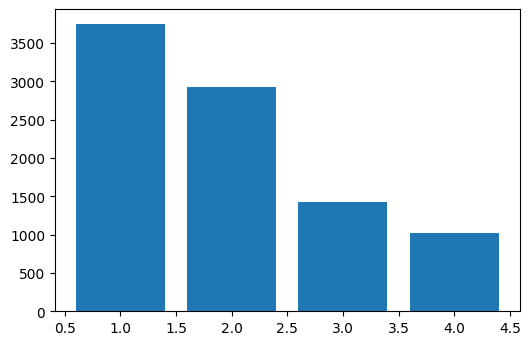

In [25]:
#reconsider the distribution of ys
ys = pd.Series(label).value_counts()
plt.figure(dpi=100)
plt.bar(ys.index, ys.values)
plt.show()
#it's not a imbalance dataset

In [0]:
X = df.drop(columns=['Customer','Response'])

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 22 columns):
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               9134 non-null int64
Policy Type                      9134 non-null object
Policy                           9

## 2.2 Possible influence of features in first layer
Based on the input features, we can use statsmodels mnlogit to fit the probabilities, which is a R-like model. Thus, we iterately analyze the characteristics of the features and decide whether to perform transformation or not

In [28]:
#state，where customers are from
X['State'].value_counts()
#the distribution of the 5 categories are balanced

California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64

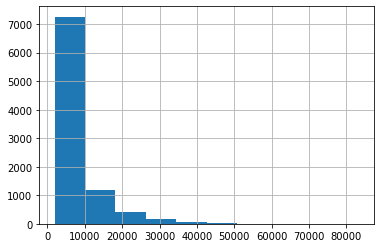

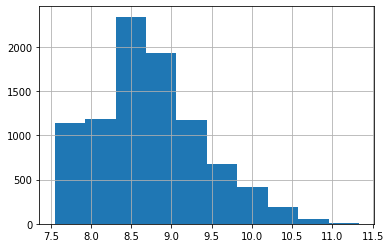

In [29]:
#customer lifetime value, the value brought by the customer
X['Customer Lifetime Value'].hist()
plt.show()
X['Customer Lifetime Value'].apply(lambda x: np.log(x)).hist()
plt.show()

In [30]:
#coverage, what accidents are covered
X['Coverage'].value_counts()
#3 categories, mainly basics

Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

In [31]:
#Education, what education levels are received of the customers
X['Education'].value_counts()
#5 categrories and the distribution is in line with the real situation

Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64

In [32]:
#Effective to date, the expire date
X['Effective To Date'].value_counts()
#we will drop this column since the information is not useful

1/10/11    195
1/27/11    194
2/14/11    186
1/26/11    181
1/17/11    180
1/19/11    179
1/3/11     178
1/31/11    178
1/20/11    173
2/26/11    169
1/28/11    169
2/19/11    168
1/5/11     167
2/27/11    167
1/11/11    166
2/4/11     164
2/28/11    161
2/10/11    161
1/2/11     160
1/21/11    160
1/29/11    160
2/22/11    158
2/3/11     158
2/5/11     158
2/7/11     157
2/12/11    156
1/23/11    155
1/18/11    154
2/1/11     154
1/15/11    153
1/14/11    152
1/25/11    151
1/7/11     151
2/11/11    151
2/18/11    149
2/2/11     149
2/25/11    149
1/8/11     149
2/21/11    148
1/1/11     148
1/24/11    147
1/9/11     146
1/13/11    145
1/30/11    145
2/6/11     144
1/6/11     143
2/23/11    143
1/16/11    142
2/24/11    139
2/16/11    139
2/13/11    139
2/9/11     137
2/17/11    136
1/22/11    136
2/8/11     134
2/20/11    132
2/15/11    130
1/12/11    126
1/4/11     115
Name: Effective To Date, dtype: int64

In [33]:
X['EmploymentStatus'].value_counts()
#5 categories; most people are employed

Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64

In [34]:
X['Gender'].value_counts()
#Males is slightly more that females

F    4658
M    4476
Name: Gender, dtype: int64

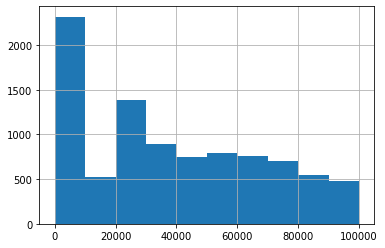

In [35]:
X['Income'].hist()
#The income is to some extent balanced, not a tailed distribution

In [36]:
X['Location Code'].value_counts()
#3 categories; 

Suburban    5779
Rural       1773
Urban       1582
Name: Location Code, dtype: int64

In [37]:
X['Marital Status'].value_counts()
#3 categories

Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64

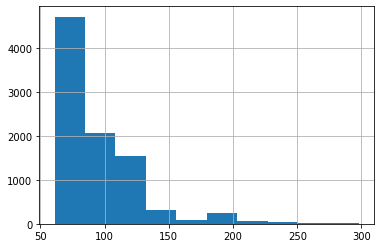

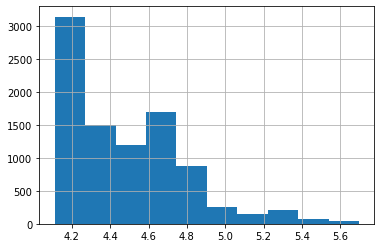

In [38]:
X['Monthly Premium Auto'].hist()
plt.show()
X['Monthly Premium Auto'].apply(lambda x: np.log(x)).hist()
plt.show()
#tailed, we need to conduct log transformation

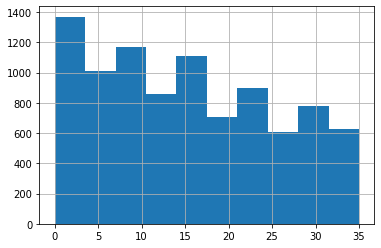

In [39]:
X['Months Since Last Claim'].hist()
#balanced distribution

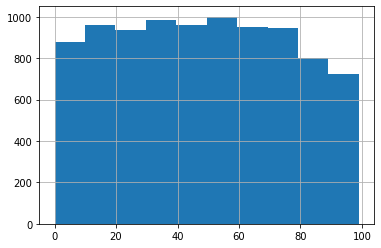

In [40]:
X['Months Since Policy Inception'].hist()
#balanced distribution

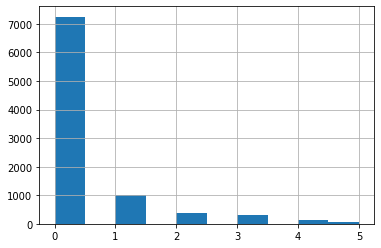

In [41]:
X['Number of Open Complaints'].hist()
#almost no complaints

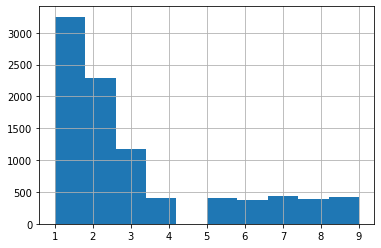

In [42]:
X['Number of Policies'].hist()
plt.show()
#trivial column; we choose to drop it

In [43]:
X['Policy Type'].value_counts()

Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: Policy Type, dtype: int64

In [44]:
X['Policy'].value_counts()
#The policy column contains all information of the policy type column/

Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: Policy, dtype: int64

In [45]:
X['Sales Channel'].value_counts()
#4 sales channels

Agent          3477
Branch         2567
Call Center    1765
Web            1325
Name: Sales Channel, dtype: int64

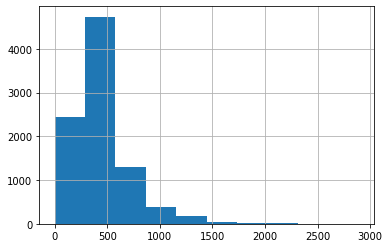

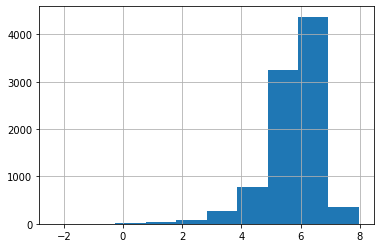

In [46]:
X['Total Claim Amount'].hist()
plt.show()
X['Total Claim Amount'].apply(lambda x: np.log(x)).hist()
plt.show()
#the distribution is tailed; after transformation, we add 1 to the distribution since there are negative values.

In [47]:
X['Vehicle Class'].value_counts()
#6 categories

Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: Vehicle Class, dtype: int64

In [48]:
X['Vehicle Size'].value_counts()
#3 categories

Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64

## 2.3 Step Forward Selection
Based on the analysis of features, we have obtained the following candidates and perform the forward selection algorithm to choose the best model

In [0]:
X.columns=['State', 'CustomerLifetimeValue', 'Coverage', 'Education',
       'EffectiveToDate', 'EmploymentStatus', 'Gender', 'Income',
       'LocationCode', 'MaritalStatus', 'MonthlyPremiumAuto',
       'MonthsSinceLastClaim', 'MonthsSincePolicyInception',
       'NumberofOpenComplaints', 'NumberofPolicies', 'PolicyType',
       'Policy', 'RenewOfferType', 'SalesChannel', 'TotalClaimAmount',
       'VehicleClass', 'VehicleSize']
# X = X[(X.RenewOfferType=='Offer1')|(X.RenewOfferType=='Offer2')|(X.RenewOfferType=='Offer3')] ; we cannot drop offer4  rows in the first layer!

In [50]:
candidates = ["C(State)", "np.log(CustomerLifetimeValue)", "C(Coverage)","C(Education)",
 "C(EmploymentStatus)", "C(Gender)", "Income", "C(LocationCode)", \
 "C(MaritalStatus)", 'np.log(MonthlyPremiumAuto)', 'C(MonthsSinceLastClaim)',\
 'MonthsSincePolicyInception', 'NumberofOpenComplaints', 'C(Policy)',\
    'C(SalesChannel)', 'TotalClaim Amount', 'C(VehicleClass)', 'C(VehicleSize)']
print("length:", len(candidates))

length: 18


In [51]:
bic_list = []
from statsmodels.formula.api import mnlogit
for string in candidates:
    try:
        formula = "RenewOfferType~"+string
        model=mnlogit(formula=formula, data=X).fit()
        bic_list.append(model.bic)  
    except:
        print('')
print(candidates[np.argmin(bic_list)])
#Based on the BIC criteria, the baseline model is RenewOfferType~Income

Optimization terminated successfully.
         Current function value: 1.265822
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.257633
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.263564
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.261701
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.242647
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.264728
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.245909
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.261843
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.249972
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.260430
  

In [52]:
#The candidates without "income"
candidate = ["C(State)", "np.log(CustomerLifetimeValue)", "C(Coverage)","C(Education)",
 "C(EmploymentStatus)", "C(Gender)", "C(LocationCode)", \
 "C(MaritalStatus)", 'np.log(MonthlyPremiumAuto)', 'C(MonthsSinceLastClaim)',\
 'MonthsSincePolicyInception', 'NumberofOpenComplaints', 'C(Policy)',\
    'C(SalesChannel)', 'TotalClaimAmount', 'C(VehicleClass)', 'C(VehicleSize)']
full=len(candidate)
best_model = "RenewOfferType~Income"
BEST_BIC = np.inf
for i in np.arange(full-1,-1,-1):
    BIC = np.empty(i+1)
    for j in range(i+1):
        candidate_formula = best_model+"+"+candidate[j]
        model = mnlogit(formula=candidate_formula,data=X).fit()
        BIC[j] = model.bic
        print(BIC)
    if BEST_BIC>np.min(BIC):
        Add_i=np.where(BIC==np.min(BIC))[0][0]
        best_model=best_model+"+"+candidate[Add_i]
    #print(Add_i)
        print("variable added:", candidate[Add_i])
   # print(best_model)
        BEST_BIC=np.min(BIC)
        candidate=np.delete(candidate,Add_i)    
    else:
        break
#the best string is stored in identifier best_model;

Optimization terminated successfully.
         Current function value: 1.245755
         Iterations 5
[ 2.29216094e+04 -9.42450893e-02 -9.86294575e-02 -4.75258053e-02
 -1.63673569e-01 -7.44889593e-02 -1.01252553e-01 -1.16850501e-01
 -1.48978564e-01 -1.52280944e-01 -1.12029225e-01 -1.45550225e-01
 -1.63722858e-01 -7.93615451e-02 -7.74191731e-02 -1.38679196e-01
 -4.89235169e-02]
Optimization terminated successfully.
         Current function value: 1.236068
         Iterations 6
[ 2.29216094e+04  2.26625641e+04 -9.86294575e-02 -4.75258053e-02
 -1.63673569e-01 -7.44889593e-02 -1.01252553e-01 -1.16850501e-01
 -1.48978564e-01 -1.52280944e-01 -1.12029225e-01 -1.45550225e-01
 -1.63722858e-01 -7.93615451e-02 -7.74191731e-02 -1.38679196e-01
 -4.89235169e-02]
Optimization terminated successfully.
         Current function value: 1.243337
         Iterations 6
[ 2.29216094e+04  2.26625641e+04  2.28227117e+04 -4.75258053e-02
 -1.63673569e-01 -7.44889593e-02 -1.01252553e-01 -1.16850501e-01
 -1.4897

In [53]:
N = 1000
def choice_mapping(X):
    guess = np.random.rand(len(X))
    return int(guess<X[0].values) + int(guess<(X[0].values+X[1].values)) + int(guess<(X[0].values+X[1].values+X[2].values))+ int(guess<(X[0].values+X[1].values+X[2].values+X[3].values))
best_mnlogit = mnlogit(formula=best_model, data=X).fit()

def first_layer(N):
    sample = X.sample(N, replace=True)[['Income', 'SalesChannel', 'CustomerLifetimeValue',\
                                        'MaritalStatus','MonthsSincePolicyInception',\
                                         'NumberofOpenComplaints','Gender']]
    proba = best_mnlogit.predict(sample)
    return proba

Optimization terminated successfully.
         Current function value: 1.201568
         Iterations 6


In [0]:
sample = X[['Income', 'SalesChannel', 'CustomerLifetimeValue',\
                                        'MaritalStatus','MonthsSincePolicyInception',\
                                         'NumberofOpenComplaints','Gender']]
proba = first_layer(1000)

In [55]:
best_model

'RenewOfferType~Income+C(SalesChannel)+np.log(CustomerLifetimeValue)+C(MaritalStatus)+MonthsSincePolicyInception+NumberofOpenComplaints+C(Gender)'

In [0]:
result = pd.merge(X, proba, how='right', left_index=True, right_index=True)

In [0]:
result.to_csv('result_proba_first_layer.csv')

In [58]:
proba

,0,1,2,3
6091,0.500856,0.237279,0.166476,0.095389
3001,0.403692,0.345509,0.169357,0.081443
5139,0.506690,0.251837,0.162930,0.078543
1558,0.663703,0.169344,0.135792,0.031161
4758,0.434500,0.263808,0.171441,0.130250
...,...,...,...,...
1049,0.136478,0.511042,0.153215,0.199265
6160,0.392212,0.326254,0.168508,0.113027
9102,0.357730,0.387118,0.148368,0.106784
5611,0.445023,0.303303,0.167977,0.083696
